In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
import sklearn.metrics as metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate, cross_val_score, RandomizedSearchCV

# Chargement des données et encodage

In [2]:
df_ml=pd.read_csv('DataML.csv', sep=',')
df_ml.columns.tolist()
df_ml

,PropertyGFATotal,ENERGYSTARScore,PropertyGFAParking,NumberofFloors,NumberofBuildings,SiteEUI(kBtu/sf),GHGEmissionsIntensity,PercentSteam,PercentElec,PercentGas,LossPerFloor,Age,LargestPropertyUseType,SecondLargestPropertyUseType,BuildingType
0,88434,65.0,0,12.0,1.0,78.900000,2.64,0.289767,0.527984,0.182249,7.876769,95,Hotel,NaN,NonResidential
1,103566,51.0,15064,11.0,1.0,94.400000,2.38,0.000000,0.467468,0.532532,8.801090,26,Hotel,Parking,NonResidential
2,961990,18.0,0,41.0,1.0,96.600000,1.92,0.268832,0.680440,0.050728,3.562546,53,Hotel,Parking,NonResidential
3,119890,67.0,12460,18.0,1.0,120.100000,4.02,0.000000,0.409070,0.590930,6.035536,42,Hotel,Parking,NonResidential
4,83008,25.0,0,11.0,1.0,76.900000,2.37,0.000000,0.428549,0.571451,6.594005,96,Other,NaN,Nonresidential COS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4900,208136,100.0,58818,7.0,1.0,21.100000,0.47,0.000000,0.559873,0.440127,3.680457,7,Other,NaN,NonResidential
4901,20246,99.0,2580,4.0,1.0,44.700001,0.93,0.000000,0.632940,0.367060,15.311720,8,Office,Parking,NonResidential
4902,13661,75.0,0,1.0,1.0,36.799999,0.26,0.000000,1.000000,0.000000,77.920793,70,Multifamily Housing,NaN,Multifamily LR (1-4)
4903,15398,93.0,0,1.0,1.0,25.200001,0.51,0.000000,0.715652,0.284348,38.514849,62,Multifamily Housing,NaN,Multifamily MR (5-9)


<AxesSubplot:>

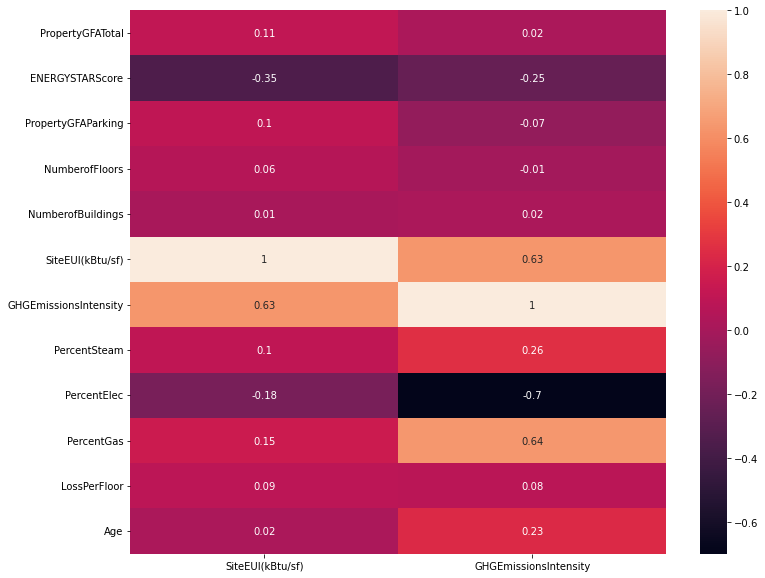

In [3]:
#Correlations des var. finales par rapport aux targets
corel = df_ml.corr().round(decimals=2)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corel[['SiteEUI(kBtu/sf)','GHGEmissionsIntensity']], annot=True)

In [4]:
enc = OneHotEncoder(handle_unknown='ignore')
# Objet OneHotEncoder pour données catégorielles 

enc_df = pd.DataFrame(  enc.fit_transform(df_ml[['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'BuildingType']]).toarray() )
# fit_transform sur les données à encoder, qui sont ensuite re-converties en dataframe

df_ml= df_ml.join(enc_df)
df_ml.drop(columns=['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'BuildingType'],inplace=True)
# Jointure sur les données et suppression des anciennes colonnes (remplacées par les versions encodées)

df_ml

,PropertyGFATotal,ENERGYSTARScore,PropertyGFAParking,NumberofFloors,NumberofBuildings,SiteEUI(kBtu/sf),GHGEmissionsIntensity,PercentSteam,PercentElec,PercentGas,...,12,13,14,15,16,17,18,19,20,21
0,88434,65.0,0,12.0,1.0,78.900000,2.64,0.289767,0.527984,0.182249,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,103566,51.0,15064,11.0,1.0,94.400000,2.38,0.000000,0.467468,0.532532,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,961990,18.0,0,41.0,1.0,96.600000,1.92,0.268832,0.680440,0.050728,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,119890,67.0,12460,18.0,1.0,120.100000,4.02,0.000000,0.409070,0.590930,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,83008,25.0,0,11.0,1.0,76.900000,2.37,0.000000,0.428549,0.571451,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4900,208136,100.0,58818,7.0,1.0,21.100000,0.47,0.000000,0.559873,0.440127,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4901,20246,99.0,2580,4.0,1.0,44.700001,0.93,0.000000,0.632940,0.367060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4902,13661,75.0,0,1.0,1.0,36.799999,0.26,0.000000,1.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4903,15398,93.0,0,1.0,1.0,25.200001,0.51,0.000000,0.715652,0.284348,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Variable noscore :
Booléen pour configurer les noms de fichiers / les données en input des modèles afin de comparer la performance des modèles en fonction de l'ajout ou non de l'EnergyStarScore (ESC) dans les données.
- noscore = False : données sans ESC
- noscore = True : Données avec ESC

In [5]:
noscore=True

# Premier modèle - electricity use

In [6]:
MLliste=df_ml.columns.tolist()

#Initialisation en fonction de la valeur de "noscore"

if noscore:
    MLliste.remove('ENERGYSTARScore')
    name='NotarScore_'
else:
    name='WithStarScore_'

In [7]:
#Création du répertoire pour écriture des outputs
rep='modele1_EnergyUse_'+name
if not rep in os.listdir('.'): 
    os.mkdir(rep)

#Pour écriture des métriqsues
metrik=open('Metrics_'+name+'.csv', "w")
print(MLliste)

['PropertyGFATotal', 'PropertyGFAParking', 'NumberofFloors', 'NumberofBuildings', 'SiteEUI(kBtu/sf)', 'GHGEmissionsIntensity', 'PercentSteam', 'PercentElec', 'PercentGas', 'LossPerFloor', 'Age', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


In [8]:
# Sélection des données en input et standardisation (robustscaler)
# y = variable à prédire

selection=df_ml[MLliste]
X=RobustScaler().fit_transform(selection)
X=pd.DataFrame(X,columns=selection.columns)
y=X['SiteEUI(kBtu/sf)']
X=X.drop(columns=['SiteEUI(kBtu/sf)','GHGEmissionsIntensity'])
y

0       1.545455
1       2.109091
2       2.189091
3       3.043636
4       1.472727
          ...   
4900   -0.556364
4901    0.301818
4902    0.014545
4903   -0.407273
4904    1.189091
Name: SiteEUI(kBtu/sf), Length: 4905, dtype: float64

In [9]:
# Cross validation - stratified k-fold avec 10 splits et 10 repeats.t
cv=RepeatedKFold(n_splits=10,n_repeats=10)

# Jeu de d'entrainement et test, split 80/20 - 972 individus pour le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


In [10]:
# Creation du régresseur, choix du randomforest car c'est une bonne solution générale
rf = RandomForestRegressor(n_estimators = 500, random_state = 42)

# Grille de paramètres
random_grid = {
    'bootstrap': [True, False],
    'max_depth': [3, 10, None],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [1, 2],
    'n_estimators': [100, 300, 500]}

# Recherche des meilleurs hyperparamètres / cross validation
clf = RandomizedSearchCV(rf, random_grid, random_state=0,cv=cv)
search = clf.fit(X_train, y_train);


In [11]:
search.get_params()

{'cv': RepeatedKFold(n_repeats=10, n_splits=10, random_state=None),
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'mse',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 500,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': 42,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(n_estimators=500, random_state=42),
 'n_iter': 10,
 'n_jobs': None,
 'param_distributions': {'bootstrap': [True, False],
  'max_depth': [3, 10, None],
  'min_samples_leaf': [1, 2, 3],
  'max_features': [1, 2],
  'n_estimators': [100, 300, 500]},
 'pre_dispatch': '

In [12]:
# Scoring du modèle

score=search.score(X_train, y_train)
print("R-squared train:", score)

y_pred=search.predict(X_test)
y_pred

score2=search.score(X_test, y_test)
print("R-squared test:", score2)


R-squared train: 0.9996098547674788
R-squared test: 0.6894687583487283


In [13]:
# Métriques du modèle

mse= metrics.mean_squared_error(y_test, y_pred)
mae= metrics.mean_absolute_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 
print("MAE: ", mae)

metrik.write(',R-squared train,R-squared train,MSE,RMSE,MAE\nEnergyUse,'+str(score)+','+str(score2)+','+str(mse)
              +','+str(mse*(1/2.0))+','+str(mae)+'\n')

MSE:  0.5380269154021151
RMSE:  0.26901345770105756
MAE:  0.454642029610833


151

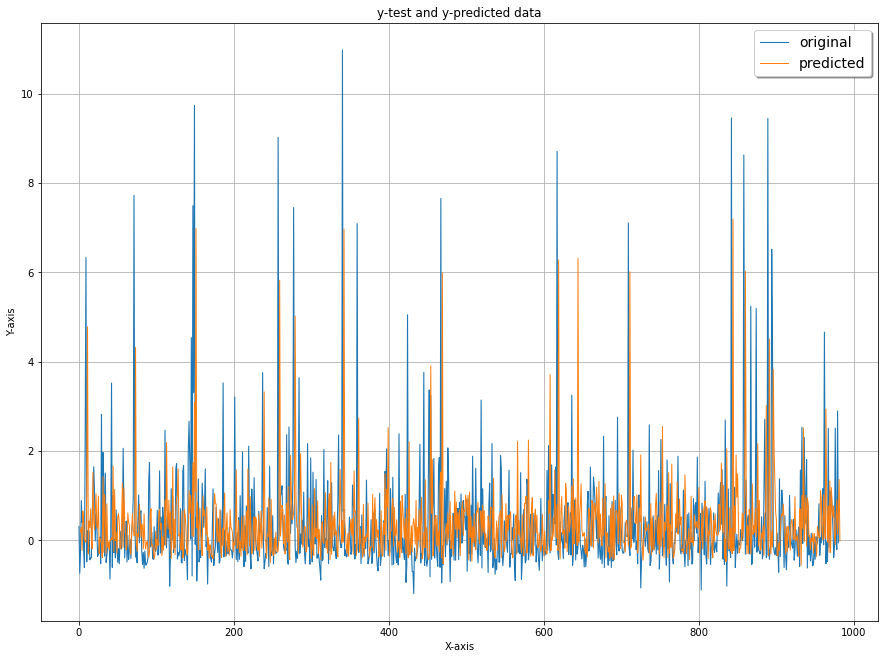

In [14]:
# Lineplot des données réelles et prédites pour "visualiser" l'efficacité du modèle 
fig, ax = plt.subplots(figsize=(15,11))
x_ax = range(len(y_test))
x_ax2 = range(len(y_test))
x_ax2 = np.array(x_ax2)
plt.plot(x_ax, y_test, linewidth=1.1, label="original")
plt.plot(x_ax2+2, y_pred, linewidth=1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True, fontsize=14)
plt.grid(True)
plt.savefig(rep+'/model1_CompPred_'+name+'.png')
plt.show() 
plt.close()

In [15]:
# Récupération du classement des features et classement par ordre d'importance
imp=search.best_estimator_.feature_importances_
order=np.argsort(search.best_estimator_.feature_importances_)[::-1]
X_train.columns[order]

Index([      'LossPerFloor',   'PropertyGFATotal',        'PercentElec',
               'PercentGas',     'NumberofFloors',                'Age',
       'PropertyGFAParking',       'PercentSteam',                   14,
                          5,                   11,                    9,
                          3,  'NumberofBuildings',                   10,
                          4,                   18,                   17,
                         19,                    2,                   13,
                          0,                   12,                    6,
                          1,                    7,                   20,
                         16,                   21,                    8,
                         15],
      dtype='object')

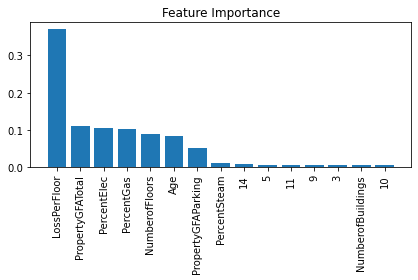

In [16]:
# Visualisation de la feature importance

plt.title('Feature Importance')
plt.bar(range(0,15), imp[order][0:15], align='center')
plt.xticks(range(0,15), X_train.columns[order][0:15], rotation=90)
plt.tight_layout()
plt.savefig(rep+'/featureImp_model1'+name+'.png')
plt.show()
plt.close()